In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras import Model, Input
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import glob
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

---

## 6.1 Data Preparation

### Load data

In [3]:
#1. List all file name in face image path
filenames = glob.glob('/content/drive/MyDrive/KMITL/ปี 3 เทอม 2/Image Processing/face_mini/*/*.jpg')
all_imgs = []


#2. Load image files and Resze (h, w,ch) -> h = w < 100, ch = 3 (R, G, B)
for i in range(len(filenames)):
    img = image.load_img(filenames[i], target_size=(80,80), interpolation="nearest")
    img = image.img_to_array(img)  #Convert image to an array
    img = img/255                  #Normalized color image
    all_imgs.append(img)


#3. Convert to numpy array
all_images = np.array(all_imgs)


#4. Split data into train and validation data
train_x, test_x = train_test_split(all_images, random_state=32, test_size=0.3)
train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)

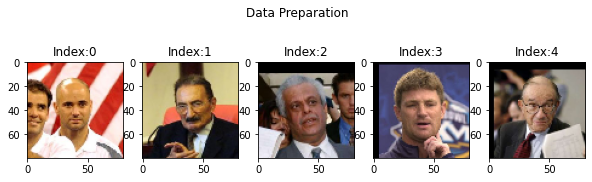

In [4]:
fig = plt.figure(figsize=(10, 3))
fig.suptitle("Data Preparation")
rows = 1
columns = 5

#Image
for i in range(5):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(train_x[i])
    plt.title('Index:'+ str(i))
plt.show()

### Add noise

In [5]:
#1. Add noise
noise_factor = 0.5


#2. Define noise parameter
noise_distribution = 'normal'
noise_mean = 0
noise_std = 1


#3. Use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=train_x.shape))
x_val_noisy = val_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=val_x.shape))
x_test_noisy = test_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=test_x.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


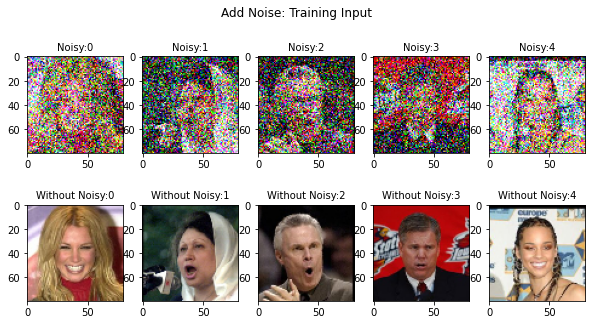

In [6]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle("Add Noise: Training Input")
rows = 2
columns = 5

#Noisy
for i in range(5):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_val_noisy[i])
    plt.title('Noisy:'+ str(i), fontsize=10)
    
#Without Noisy
for i in range(5):
    fig.add_subplot(rows, columns, 6+i)
    plt.imshow(val_x[i])
    plt.title('Without Noisy:'+ str(i), fontsize=10)

plt.show()

---

## 6.2 Create Model (Autoencoder)

In [7]:
# Create model function
def create_model(optimizer='adam'):
  input_img = Input(shape=(80, 80, 3))

  #encoder layers
  x1 = Conv2D(256, (3,3), activation='relu', padding='same')(input_img)
  x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x1)
  x2 = MaxPool2D((2, 2))(x2)
  encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

  #decoder architecture
  x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
  x3 = UpSampling2D((2, 2))(x3)
  x4 = Conv2D(128, (3,3), activation='relu', padding='same')(x3)
  x5 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
  decoded = Conv2D(3, (3,3), padding='same')(x5)

  #construct the autoencoder model
  autoencoder = Model(input_img, decoded)
  autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])

  return autoencoder


#Declare KERAS parameter management of Model
model = KerasRegressor(build_fn=create_model, epochs=2, batch_size=16, verbose=0)

---

## 6.3 Hyperparameter Tuning

### (a) Create GridSearchCV()

In [8]:
#Define Grid Search Parameter
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
batch_size = [8, 16, 32]
epochs = [2, 4, 6]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

grid = GridSearchCV(estimator=model,
                     verbose=0,
                     cv=2,
                     param_grid=param_grid)

In [9]:
grid_result = grid.fit(x_train_noisy, train_x)

In [10]:
print('Best params:', grid_result.best_params_)
print('Best score:', grid_result.best_score_)

Best params: {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adam'}
Best score: -0.008547437377274036


-0.031329 (0.003942) with: {'batch_size': 8, 'epochs': 2, 'optimizer': 'SGD'}
-0.039975 (0.019844) with: {'batch_size': 8, 'epochs': 2, 'optimizer': 'RMSprop'}
-0.202505 (0.022717) with: {'batch_size': 8, 'epochs': 2, 'optimizer': 'Adadelta'}
-0.011725 (0.001654) with: {'batch_size': 8, 'epochs': 2, 'optimizer': 'Adam'}
-0.023757 (0.000140) with: {'batch_size': 8, 'epochs': 4, 'optimizer': 'SGD'}
-0.027627 (0.006391) with: {'batch_size': 8, 'epochs': 4, 'optimizer': 'RMSprop'}
-0.177747 (0.001806) with: {'batch_size': 8, 'epochs': 4, 'optimizer': 'Adadelta'}
-0.009622 (0.000243) with: {'batch_size': 8, 'epochs': 4, 'optimizer': 'Adam'}
-0.021992 (0.000131) with: {'batch_size': 8, 'epochs': 6, 'optimizer': 'SGD'}
-0.015495 (0.001429) with: {'batch_size': 8, 'epochs': 6, 'optimizer': 'RMSprop'}
-0.068187 (0.025718) with: {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adadelta'}
-0.008547 (0.000177) with: {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adam'}
-0.045774 (0.000455) with: {'batch

<BarContainer object of 36 artists>

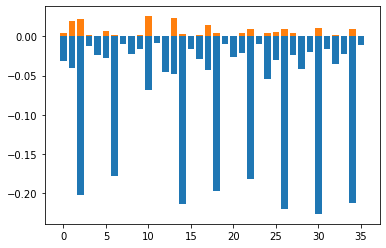

In [11]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

plt.bar(range(len(means)), means)
plt.bar(range(len(stds)), stds)

### (b) Create RandomizedSearchCV()

In [12]:
#Define Random Search Parameters
param_random_search = {'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam'],
                 'batch_size': list(np.linspace(8, 64, 5, dtype=int)),
                 'epochs': list(np.linspace(1, 10, 4, dtype=int))}

grid_rand = RandomizedSearchCV(estimator=model,
                               verbose=0,
                               cv=2,
                               n_jobs=1,
                               random_state=10,
                               n_iter=20,  #number of random parameter
                               param_distributions=param_random_search)

In [13]:
grid_rand_result = grid_rand.fit(x_train_noisy, train_x)

In [14]:
print('Best params:', grid_rand_result.best_params_)
print('Best score:', grid_rand_result.best_score_)

Best params: {'optimizer': 'Adam', 'epochs': 7, 'batch_size': 36}
Best score: -0.013054289389401674


-0.038592 (0.009845) with: {'optimizer': 'RMSprop', 'epochs': 7, 'batch_size': 36}
-0.188537 (0.006748) with: {'optimizer': 'Adadelta', 'epochs': 10, 'batch_size': 36}
-0.199476 (0.013650) with: {'optimizer': 'Adadelta', 'epochs': 7, 'batch_size': 22}
-0.124789 (0.005363) with: {'optimizer': 'SGD', 'epochs': 1, 'batch_size': 36}
-0.050073 (0.004491) with: {'optimizer': 'Adam', 'epochs': 1, 'batch_size': 36}
-0.095026 (0.000085) with: {'optimizer': 'RMSprop', 'epochs': 1, 'batch_size': 64}
-0.044174 (0.016187) with: {'optimizer': 'RMSprop', 'epochs': 4, 'batch_size': 22}
-0.018315 (0.002674) with: {'optimizer': 'Adam', 'epochs': 1, 'batch_size': 8}
-0.023495 (0.000629) with: {'optimizer': 'RMSprop', 'epochs': 4, 'batch_size': 36}
-0.033830 (0.012035) with: {'optimizer': 'Adam', 'epochs': 1, 'batch_size': 22}
-0.029044 (0.000091) with: {'optimizer': 'SGD', 'epochs': 10, 'batch_size': 36}
-0.242249 (0.023821) with: {'optimizer': 'Adadelta', 'epochs': 1, 'batch_size': 36}
-0.013054 (0.0007

<BarContainer object of 20 artists>

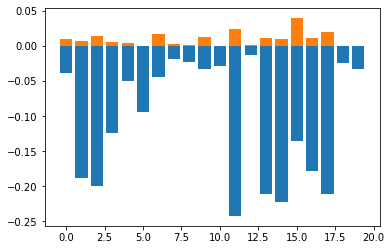

In [15]:
means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']


for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

plt.bar(range(len(means)), means)
plt.bar(range(len(stds)), stds)